In [1]:
import altair as alt
import itertools
import pickle
import math

import lightgbm
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
import sklearn.ensemble

In [2]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
get_ipython().magic("load_ext autoreload")
get_ipython().magic("autoreload 2")

In [3]:
data = sklearn.datasets.load_diabetes(as_frame=True)

df = data["frame"].reset_index(drop=True)

<AxesSubplot:ylabel='Frequency'>

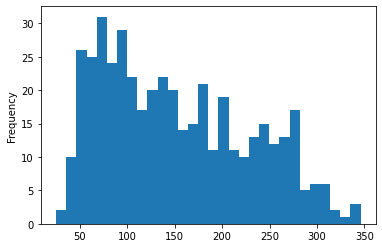

In [4]:
df['target'].plot.hist(bins=30)

In [5]:
# only take a 100 because interventional perturbation by default only takes 100 background samples.
# https://github.com/slundberg/shap/blob/45b85c1837283fdaeed7440ec6365a886af4a333/shap/maskers/_tabular.py#L18
ndf = (
    (df[["age", "sex", "bmi", "bp", "s1", "s2", "s3", "s4", "s5", "s6"]] * 100)
    .assign(target=df["target"])
    .head(100)
)

In [6]:
ndf.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',
       'target'],
      dtype='object')

In [7]:
ndf.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,3.807591,5.068012,6.169621,2.187235,-4.422350,-3.482076,-4.340085,-0.259226,1.990842,-1.764613,151.0
1,-0.188202,-4.464164,-5.147406,-2.632783,-0.844872,-1.916334,7.441156,-3.949338,-6.832974,-9.220405,75.0
2,8.529891,5.068012,4.445121,-0.567061,-4.559945,-3.419447,-3.235593,-0.259226,0.286377,-2.593034,141.0
3,-8.906294,-4.464164,-1.159501,-3.665645,1.219057,2.499059,-3.603757,3.430886,2.269202,-0.936191,206.0
4,0.538306,-4.464164,-3.638469,2.187235,0.393485,1.559614,0.814208,-0.259226,-3.199144,-4.664087,135.0


In [8]:
ndf.shape

(100, 11)

In [9]:
feature_cols = [
    "s1",
    "s2",
]

X, y = (
    ndf[feature_cols],
    ndf["target"],
)

model = DecisionTreeRegressor(criterion="mse", max_depth=1).fit(X, y)

[Text(167.4, 163.07999999999998, 'X[0] <= 0.669\nmse = 4736.686\nsamples = 100\nvalue = 133.56'),
 Text(83.7, 54.360000000000014, 'mse = 4711.816\nsamples = 71\nvalue = 127.394'),
 Text(251.10000000000002, 54.360000000000014, 'mse = 4476.64\nsamples = 29\nvalue = 148.655')]

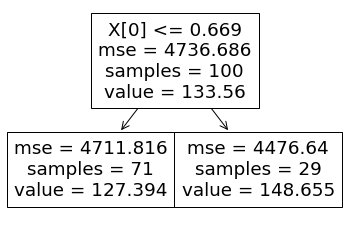

In [10]:
plot_tree(model)

In [11]:
explainer_pdte = shap.TreeExplainer(model, data=None, feature_perturbation='tree_path_dependent')

In [12]:
X.shape

(100, 2)

In [13]:
explainer_ite = shap.TreeExplainer(model, data=X, feature_perturbation='interventional')

In [14]:
explainer_pdte.expected_value

array([133.56])

In [16]:
ndf['target'].mean()

133.56

In [17]:
model.predict(ndf[feature_cols]).mean()

133.55999999999997

In [18]:
explainer_ite.expected_value

133.55999999999997

In [19]:
example_to_explain = df.iloc[0]

In [20]:
example_to_explain[feature_cols]

s1   -0.044223
s2   -0.034821
Name: 0, dtype: float64

In [21]:
model.predict([example_to_explain[feature_cols]])

array([127.3943662])

In [22]:
shap_values_pdte = explainer_pdte.shap_values(example_to_explain[feature_cols])
shap_values_ite = explainer_ite.shap_values(example_to_explain[feature_cols])

In [23]:
shap_values_pdte

array([-6.1656338,  0.       ])

In [24]:
shap_values_ite

array([-6.16563293,  0.        ])

In [25]:
sum(shap_values_pdte) + explainer_pdte.expected_value

array([127.3943662])

In [26]:
sum(shap_values_ite) + explainer_ite.expected_value

127.39436706542966

Shapley values for two features are

\begin{align*}
\phi_1(v) &= \frac{1}{2} (v_{\{1\}} - v_{\emptyset}) + \frac{1}{2} (v_{\{1, 2\}} - v_{\{2\}}) \\
\phi_2(v) &= \frac{1}{2} (v_{\{2\}} - v_{\emptyset}) + \frac{1}{2} (v_{\{1, 2\}} - v_{\{1\}})
\end{align*}


# manual calculation for PDTE

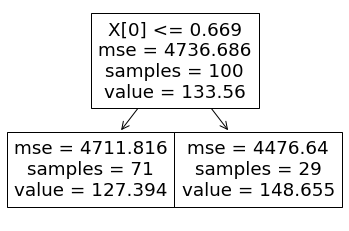

In [53]:
n_left = 71
n_right = 29
cutoff = 0.669
l_left = 127.394
l_right = 148.655

$v(\emptyset)$

In [49]:
v_emptyset = (n_left * l_left + n_right * l_right) / (n_left + n_right)
v_emptyset

133.55969000000002

$v(\{1\})$

In [54]:
example_to_explain['s1'] < cutoff

True

In [55]:
v_1 = l_left
v_1

127.394

In [58]:
v_2 = v_emptyset
v_2

133.55969000000002

In [59]:
v_12 = l_left
v_12

127.394

In [60]:
phi_1 = 0.5 * (v_1 - v_emptyset) + 0.5 * (v_12 - v_2)
phi_1

-6.165690000000012

In [61]:
phi_1 = 0.5 * (v_2 - v_emptyset) + 0.5 * (v_12 - v_1)
phi_1

0.0

# manual calculation for ITE

$v(\emptyset)$

In [35]:
v_emptyset = model.predict(X).mean()
v_emptyset

133.55999999999997

$v(\{1\})$

In [36]:
v_1 = model.predict(X.assign(s1=example_to_explain['s1'])).mean()
v_1

127.39436619718305

In [37]:
v_2 = model.predict(X.assign(s2=example_to_explain['s2'])).mean()
v_2

133.55999999999997

In [44]:
v_12 = model.predict([example_to_explain[['s1', 's2']]]).mean()
v_12

127.3943661971831

In [46]:
phi_1 = 0.5 * (v_1 - v_emptyset) + 0.5 * (v_12 - v_2)
phi_1

-6.165633802816899

In [47]:
phi_1 = 0.5 * (v_2 - v_emptyset) + 0.5 * (v_12 - v_1)
phi_1

2.842170943040401e-14